In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
import pickle
import numpy
from scipy import special
numpy.random.seed(1)
from scipy import optimize
import corner
import bovy_mcmc
from galpy.util import bovy_plot, save_pickles
import MWPotential2014Likelihood
from matplotlib.ticker import NullFormatter
from matplotlib import gridspec, cm
%pylab inline
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
save_figures= True
# Read the necessary data
#First read the surface densities
surffile= '../mwpot14data/bovyrix13kzdata.csv'
if not surffile is None and os.path.exists(surffile):
    surf= numpy.loadtxt(surffile,delimiter=',')
    surfrs= surf[:,2]
    kzs= surf[:,6]
    kzerrs= surf[:,7]
# Then the terminal velocities
cl_glon, cl_vterm, cl_corr= MWPotential2014Likelihood.readClemens(dsinl=0.125)
mc_glon, mc_vterm, mc_corr= MWPotential2014Likelihood.readMcClureGriffiths(dsinl=0.125)
termdata= (cl_glon,cl_vterm,cl_corr,
           mc_glon,mc_vterm,mc_corr)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib
/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)



# MWPotential2014 constraints with variable halo flattening

In [3]:
def fit(fitc=False,fitvoro=False,c=1.,dblexp=False,plots=True):
    init_params= [0.5,0.45,numpy.log(2.5/8.),numpy.log(0.4/8.),
                  numpy.log(20./8.),0.,0.]
    if fitvoro:
        init_params.extend([1.,1.])
    if fitc:
        init_params.append(1.)
    funcargs= (c,surfrs,kzs,kzerrs,termdata,7.,fitc,fitvoro,dblexp)
    params= optimize.fmin_powell(MWPotential2014Likelihood.like_func,
                                 init_params,args=funcargs,disp=False)
    if plots:
        if fitvoro:
            ro, vo= _REFR0*params[8],_REFV0*params[7]
        else:
            ro, vo= _REFR0, _REFV0
        pot= MWPotential2014Likelihood.setup_potential(params,c,fitc,dblexp,ro,vo)
        subplot(1,3,1)
        MWPotential2014Likelihood.plotRotcurve(pot)
        subplot(1,3,2)
        MWPotential2014Likelihood.plotKz(pot,surfrs,kzs,kzerrs,ro,vo)
        subplot(1,3,3)
        MWPotential2014Likelihood.plotTerm(pot,termdata,ro,vo)
        tight_layout()
    return (params,MWPotential2014Likelihood.like_func(params,*funcargs))

In [4]:
def sample(nsamples=1000,params=None,fitc=False,fitvoro=False,c=1.,dblexp=False,plots=True):
    if params is None:
        params= fit(fitc=fitc,fitvoro=fitvoro,c=c,dblexp=dblexp,plots=False)[0]
    funcargs= (c,surfrs,kzs,kzerrs,termdata,7.,fitc,fitvoro,dblexp)
    samples=\
        bovy_mcmc.markovpy(params,0.2,
                           lambda x: -MWPotential2014Likelihood.like_func(x,*funcargs),(),
                           isDomainFinite=[[False,False] for ii in range(len(params))],
                           domain= [[0.,0.] for ii in range(len(params))],
                           nsamples=nsamples,
                           nwalkers=2*len(params))
    samples= numpy.array(samples).T
    if plots: plot_samples(samples,fitc)
    return samples
def plot_samples(samples,fitc,fitvoro):
    labels= [r'$f_d$',r'$f_h$',r'$a / \mathrm{kpc}$',r'$b / \mathrm{pc}$',
             r'$r_s / \mathrm{kpc}$']
    ranges= [(0.,1.),(0.,1.),(2.,4.49),(150.,445.),(0.,39.)]
    if fitvoro:
        labels.extend([r'$V_c(R_0) / \mathrm{km\,s}^{-1}$',
                       r'$R_0 / \mathrm{kpc}$'])
        ranges.extend([(200.,240.),(7.7,8.7)])
    if fitc: 
        labels.append(r'$c$')
        ranges.append((0.,4.))
    subset= numpy.ones(len(samples),dtype='bool')
    subset[5:7]= False
    plotsamples= samples[subset]
    plotsamples[2]= numpy.exp(samples[2])*_REFR0
    plotsamples[3]= numpy.exp(samples[3])*1000.*_REFR0
    plotsamples[4]= numpy.exp(samples[4])*_REFR0
    if fitvoro:
        plotsamples[5]= samples[7]*_REFV0
        plotsamples[6]= samples[8]*_REFR0
    corner.corner(plotsamples.T,quantiles=[0.16, 0.5, 0.84],labels=labels,
                  show_titles=True, title_args={"fontsize": 12},range=ranges)

## Basic, Bovy (2015) fit with $c=1$

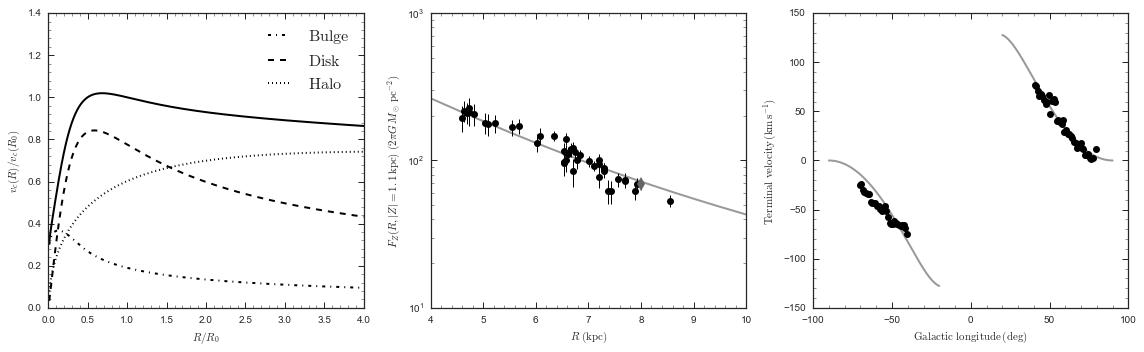

In [5]:
figsize(16,5)
p_b15= fit(fitc=False,c=1.)

Best-fit parameters and minus log likelihood:

In [6]:
print p_b15

(array([ 0.60122692,  0.36273147, -0.97591502, -3.34169377,  0.71877924,
       -0.01519337, -0.01928001]), 145.67051777235892)


## Fits with $c\neq1$

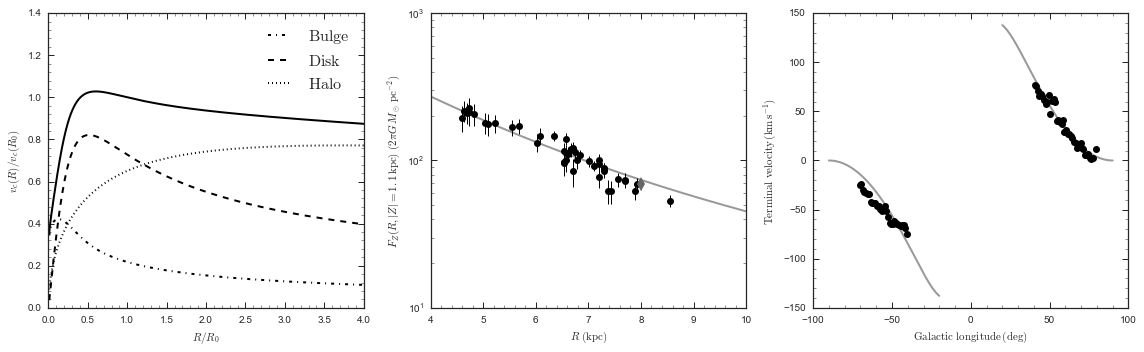

In [7]:
figsize(16,5)
p_b15_cp5= fit(fitc=False,c=0.5)

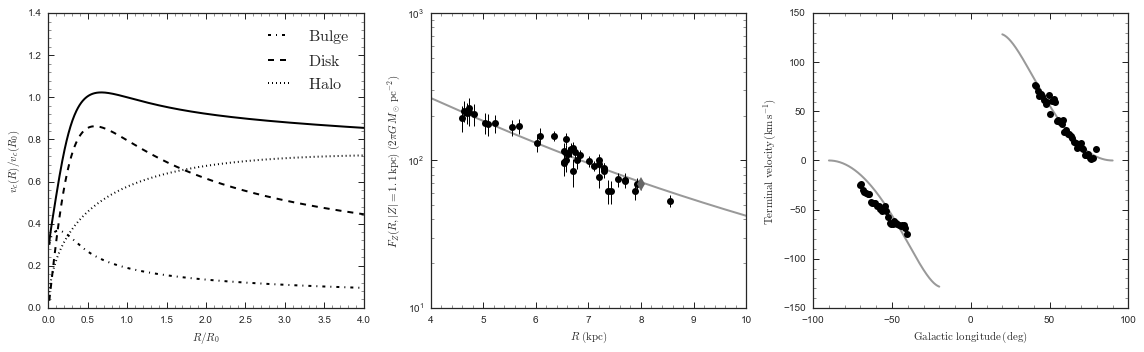

In [8]:
figsize(16,5)
p_b15_c1p5= fit(fitc=False,c=1.5)

All look pretty similar...

In [9]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,4.1,0.1)
    bf_params= []
    for c in cs:
        dum= fit(fitc=False,c=c)
        bf_params.append(dum[0])
    save_pickles(bf_savefilename,cs,bf_params)

##Fits with free $c$

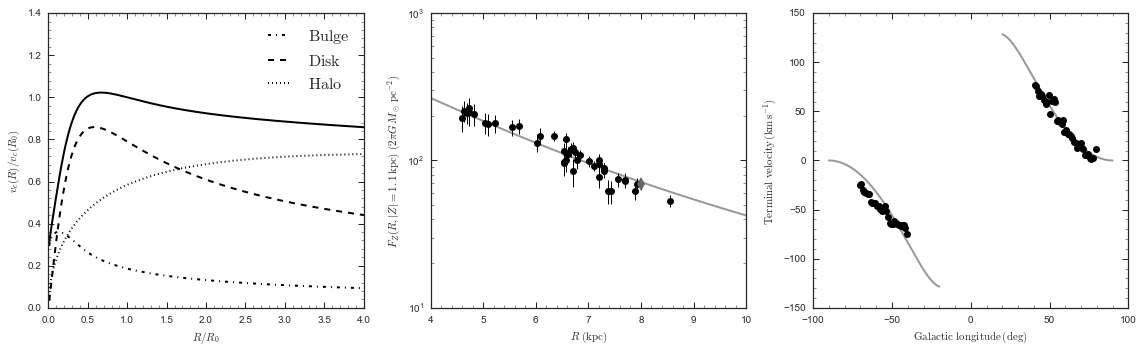

In [10]:
figsize(16,5)
p_b15_cfree= fit(fitc=True,c=None)

In [11]:
samples_savefilename= 'mwpot14varyc-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample(nsamples= 100000,params=p_b15_cfree[0],fitc=True,c=None,plots=False)
    save_pickles(samples_savefilename,s)

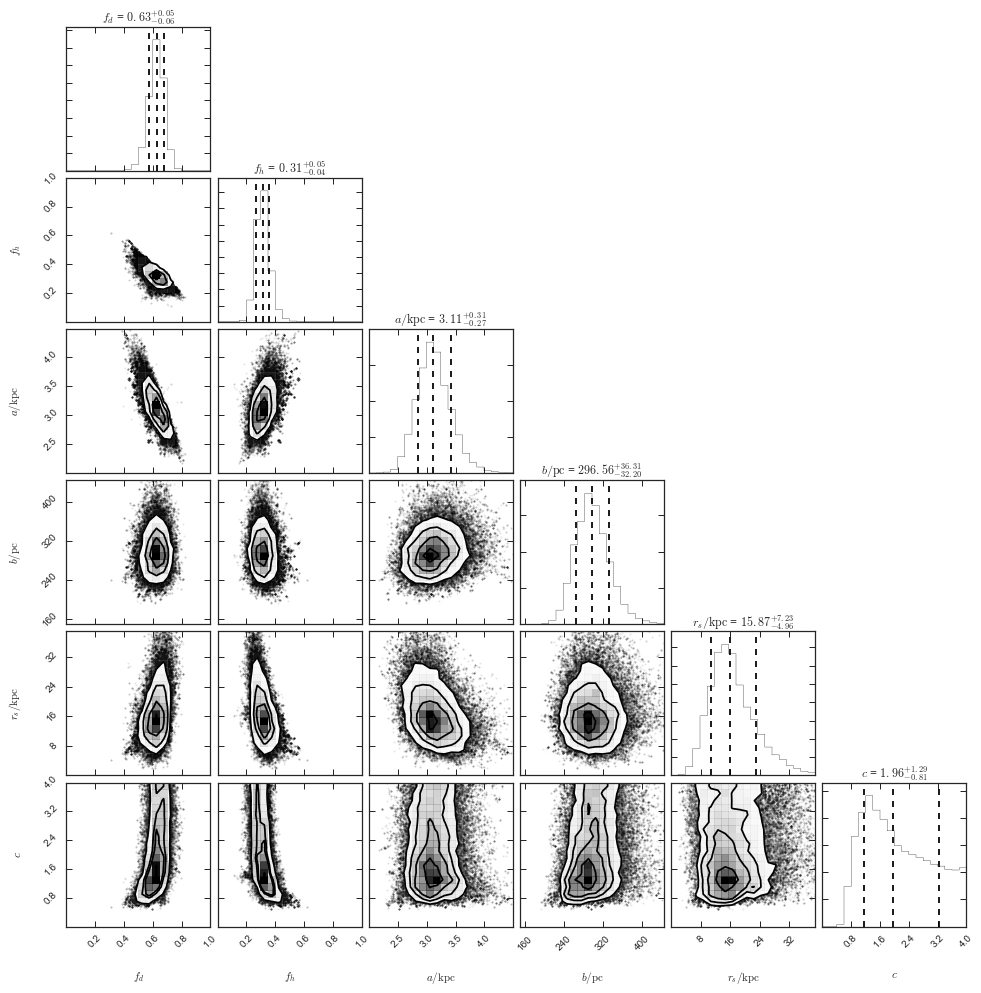

In [12]:
plot_samples(s,True,False)

Nice plot of the $c$ dependence of the other quantities

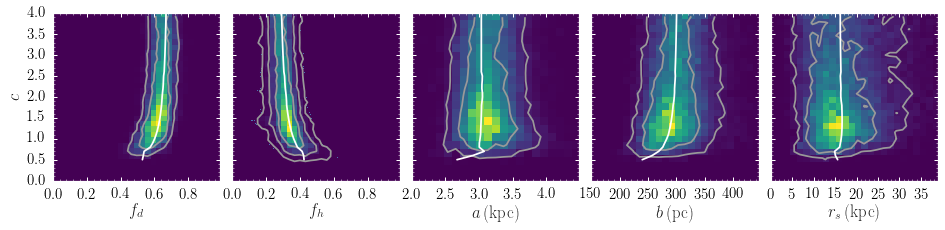

In [13]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
cmap= cm.viridis
levels= list(special.erf(numpy.arange(1,3)/numpy.sqrt(2.)))
levels.append(1.01)
def axes_white():
    for k, spine in gca().spines.items():  #ax.spines is a dictionary
        spine.set_color('w')
    gca().tick_params(axis='x',which='both',colors='w')
    gca().tick_params(axis='y',which='both',colors='w')
    [t.set_color('k') for t in gca().xaxis.get_ticklabels()]
    [t.set_color('k') for t in gca().yaxis.get_ticklabels()]
    return None
figsize(16,3)
gs=  gridspec.GridSpec(1,5,wspace=0.025)
subplot(gs[0])
bovy_plot.scatterplot(s[0],s[7],',',gcf=True,bins=31,cmap=cmap,cntrcolors='0.6',
                     xrange=[0.,.99],yrange=[0.,4.],levels=levels,
                     xlabel=r'$f_d$',ylabel=r'$c$',zorder=1)
bovy_plot.bovy_plot([bp[0] for bp in bf_params],cs,'w-',overplot=True)
axes_white()
subplot(gs[1])
bovy_plot.scatterplot(s[1],s[7],',',gcf=True,bins=31,cmap=cmap,cntrcolors='0.6',
                     xrange=[0.,.99],yrange=[0.,4.],
                     xlabel=r'$f_h$')
bovy_plot.bovy_plot([bp[1] for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
subplot(gs[2])
bovy_plot.scatterplot(numpy.exp(s[2])*_REFR0,s[7],',',gcf=True,bins=21,levels=levels,
                     xrange=[2.,4.49],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                     xlabel=r'$a\,(\mathrm{kpc})$')
bovy_plot.bovy_plot([numpy.exp(bp[2])*_REFR0 for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
subplot(gs[3])
bovy_plot.scatterplot(numpy.exp(s[3])*_REFR0*1000.,s[7],',',gcf=True,bins=26,levels=levels,
                     xrange=[150.,445.],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                     xlabel=r'$b\,(\mathrm{pc})$')
bovy_plot.bovy_plot([numpy.exp(bp[3])*_REFR0*1000. for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
subplot(gs[4])
bovy_plot.scatterplot(numpy.exp(s[4])*_REFR0,s[7],',',gcf=True,bins=26,levels=levels,
                     xrange=[0.,39.],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                     xlabel=r'$r_s\,(\mathrm{kpc})$')
bovy_plot.bovy_plot([numpy.exp(bp[4])*_REFR0 for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
if save_figures:
    plt.savefig('mwpot14-varyc.pdf',bbox_inches='tight')

2.5% and 0.5% lower limits: 0.78, 0.66


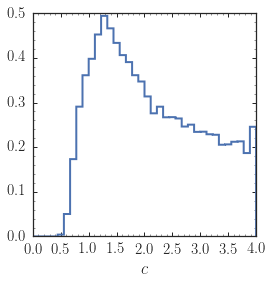

In [14]:
figsize(4,4)
dum= bovy_plot.bovy_hist(s[7],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c$',xrange=[0.,4.],normed=True)
sortedc= numpy.array(sorted(s[7]))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])

## Using an exponential disk instead of a Miyamoto-Nagai disk

$c=1$:

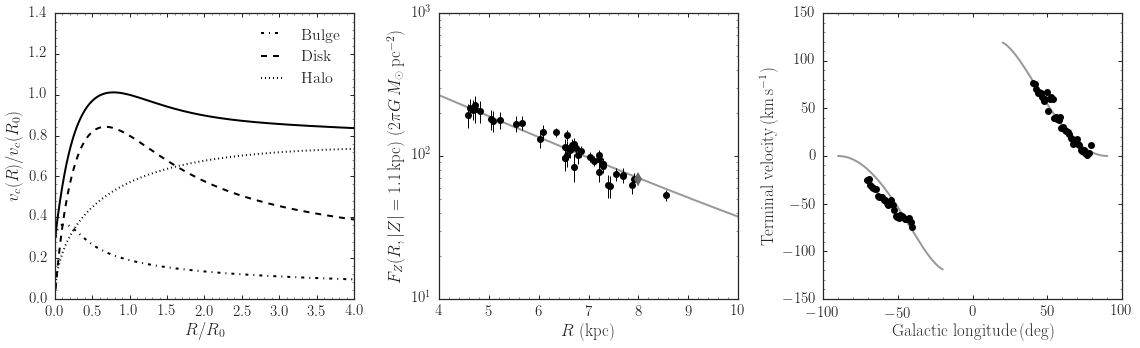

In [15]:
figsize(16,5)
p_exp= fit(fitc=False,c=1.,dblexp=True)

$c=0.5$:

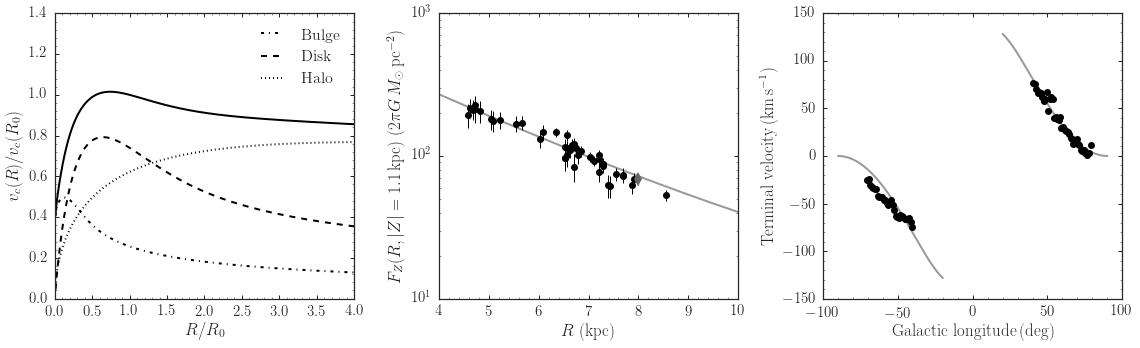

In [16]:
figsize(16,5)
p_exp_cp5= fit(fitc=False,c=0.5,dblexp=True)

$c=1.5$:

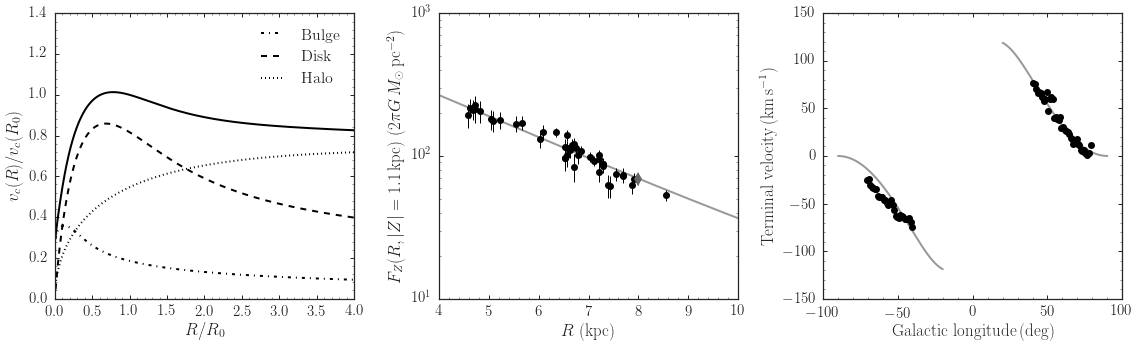

In [17]:
figsize(16,5)
p_exp_c1p5= fit(fitc=False,c=1.5,dblexp=True)

Leave $c$ free:

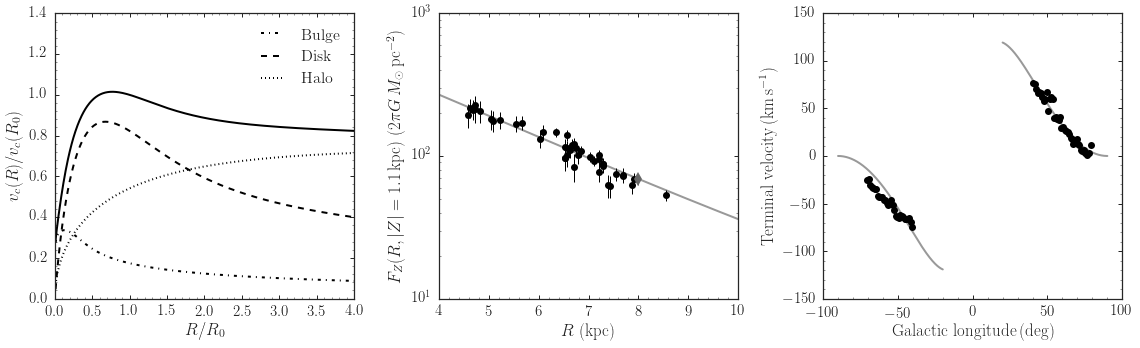

In [18]:
figsize(16,5)
p_exp_cfree= fit(fitc=True,c=None,dblexp=True)

In [19]:
bf_savefilename= 'mwpot14varyc-dblexp-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,4.1,0.1)
    bf_params= []
    for c in cs:
        dum= fit(fitc=False,c=c,dblexp=True,plots=False)
        bf_params.append(dum[0])
    save_pickles(bf_savefilename,cs,bf_params)

In [20]:
samples_savefilename= 'mwpot14varyc-dblexp-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample(nsamples=100000,params=p_exp_cfree[0],fitc=True,c=None,plots=False,dblexp=True)
    save_pickles(samples_savefilename,s)

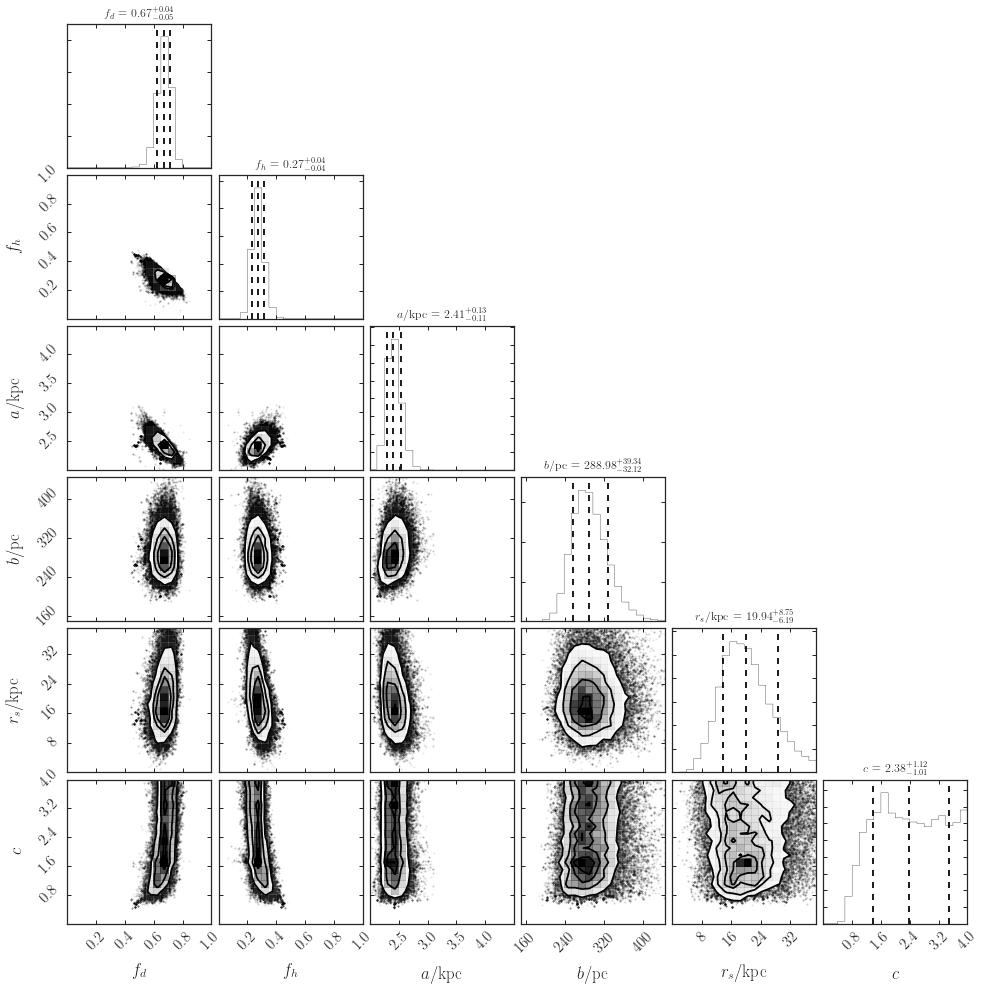

In [21]:
plot_samples(s,True,False)

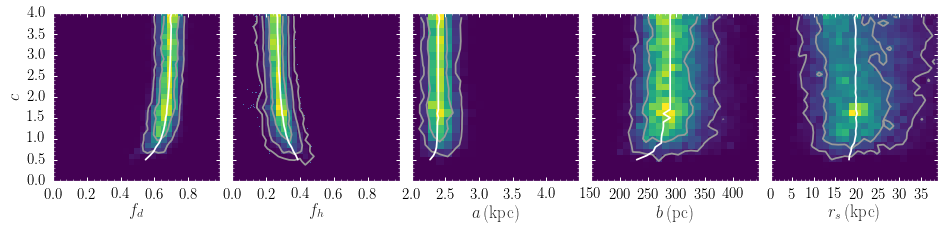

In [22]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
cmap= cm.viridis
levels= list(special.erf(numpy.arange(1,3)/numpy.sqrt(2.)))
levels.append(1.01)
def axes_white():
    for k, spine in gca().spines.items():  #ax.spines is a dictionary
        spine.set_color('w')
    gca().tick_params(axis='x',which='both',colors='w')
    gca().tick_params(axis='y',which='both',colors='w')
    [t.set_color('k') for t in gca().xaxis.get_ticklabels()]
    [t.set_color('k') for t in gca().yaxis.get_ticklabels()]
    return None
figsize(16,3)
gs=  gridspec.GridSpec(1,5,wspace=0.025)
subplot(gs[0])
bovy_plot.scatterplot(s[0],s[7],',',gcf=True,bins=31,cmap=cmap,cntrcolors='0.6',
                     xrange=[0.,.99],yrange=[0.,4.],levels=levels,
                     xlabel=r'$f_d$',ylabel=r'$c$',zorder=1)
bovy_plot.bovy_plot([bp[0] for bp in bf_params],cs,'w-',overplot=True)
axes_white()
subplot(gs[1])
bovy_plot.scatterplot(s[1],s[7],',',gcf=True,bins=31,cmap=cmap,cntrcolors='0.6',
                     xrange=[0.,.99],yrange=[0.,4.],
                     xlabel=r'$f_h$')
bovy_plot.bovy_plot([bp[1] for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
subplot(gs[2])
bovy_plot.scatterplot(numpy.exp(s[2])*_REFR0,s[7],',',gcf=True,bins=21,levels=levels,
                     xrange=[2.,4.49],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                     xlabel=r'$a\,(\mathrm{kpc})$')
bovy_plot.bovy_plot([numpy.exp(bp[2])*_REFR0 for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
subplot(gs[3])
bovy_plot.scatterplot(numpy.exp(s[3])*_REFR0*1000.,s[7],',',gcf=True,bins=26,levels=levels,
                     xrange=[150.,445.],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                     xlabel=r'$b\,(\mathrm{pc})$')
bovy_plot.bovy_plot([numpy.exp(bp[3])*_REFR0*1000. for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
subplot(gs[4])
bovy_plot.scatterplot(numpy.exp(s[4])*_REFR0,s[7],',',gcf=True,bins=26,levels=levels,
                     xrange=[0.,39.],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                     xlabel=r'$r_s\,(\mathrm{kpc})$')
bovy_plot.bovy_plot([numpy.exp(bp[4])*_REFR0 for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
if save_figures:
    plt.savefig('mwpot14-dblexp-varyc.pdf',bbox_inches='tight')

2.5% and 0.5% lower limits: 0.85, 0.68


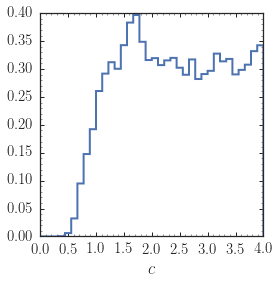

In [23]:
figsize(4,4)
dum= bovy_plot.bovy_hist(s[7],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c$',xrange=[0.,4.],normed=True)
sortedc= numpy.array(sorted(s[7]))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])